# ASCAT data from EUMETSAT - the easy way

Note: This notebook depends on functionality which is set to be released in the next version of this package. If you have already installed `ascat` in your environment via PyPi, you will need to install the current version of the master branch from GitHub instead:

```bash
pip uninstall ascat
pip install git+https://github.com/TUW-GEO/ascat.git
```

It also depends on version 3.0.0 of the `eodag` package, which is in pre-release at the time of writing and is not a dependency of this package. To install the proper version, you can run:

```bash
pip install eodag==3.0.0b3
```

This newest version of `eodag` includes support for the EUMETSAT Data Store, which will soon be available in the standard PyPi release of the package.

Finally, the notebook depends on cartopy, which can be installed via pip:
```bash
pip install cartopy
```

The rest of this package's dependencies can be installed using the environment.yml in the root of the repository.

In [1]:
# %pip uninstall ascat
%pip install git+https://github.com/TUW-GEO/ascat.git
%pip install eodag==3.0.0b3
%pip install cartopy

Looking in indexes: https://pypi.geo.tuwien.ac.at/simple, https://pypi.org/simple
  Cloning https://github.com/TUW-GEO/ascat.git to /tmp/pip-req-build-hzd19p_e
  Running command git clone --filter=blob:none --quiet https://github.com/TUW-GEO/ascat.git /tmp/pip-req-build-hzd19p_e
  Resolved https://github.com/TUW-GEO/ascat.git to commit 46b4fb63f020f325a384a6a90ad951c64bde30de
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ascat: filename=ascat-2.4.3.post1.dev27+g46b4fb6-py3-none-any.whl size=350631 sha256=9e6521aa0a6d527ab8ee4c2db9737cf3fa397c56c0d96f3b56f41fb2ee6c59ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-bblxvkkh/wheels/e7/f1/92/8156434da78d3f75f124aaf72b989b7c05f45e484919d7324c
Successfully built ascat
  Attempting uninstall: ascat
    Found existing installation: ascat 2.4.3.post1.dev25+g537b933
    Unin

In [2]:
from pathlib import Path

import xarray as xr

from eodag import EODataAccessGateway
from eodag import setup_logging
from ascat.eumetsat.level2 import AscatL2File

setup_logging(verbose=1, no_progress_bar=True)
dag = EODataAccessGateway()

/home/charriso/micromamba/envs/eodag_nb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can easily access HSAF ASCAT soil moisture products from the EUMETSAT Data Store using EODAG.

EODAG ([Earth Observation Data Access Gateway](https://eodag.readthedocs.io/en/latest/index.html)) is a python library that provides a unified API to search, download and manage EO data from multiple providers.

We could, alternatively, use EUMETSAT's own Python library ([EUMDAC](https://user.eumetsat.int/resources/user-guides/eumetsat-data-access-client-eumdac-guide)), but EODAG provides a more user-friendly interface, supports multiple providers, and comes with functionality for tracking data that have already been downloaded.

To set things up, we just need to get an API key and provide it to EODAG. If you do not already have an account with EUMETSAT, you can create one [here](https://eoportal.eumetsat.int/userMgmt/register.faces). Then, go to the [API information page](https://api.eumetsat.int/api-key/) and log in to get your consumer key and consumer secret.

You can follow the directions on [Configure EODAG](https://eodag.readthedocs.io/en/latest/getting_started_guide/configure.html#configure) to save your credentials (consumer key as "username" and consumer secret as "password") in EODAG's configuration file.

Alternatively, you can configure authentication from python itself as follows:

In [3]:
# dag.update_providers_config("""
#     eumetsat_ds:
#         auth:
#             username: placeholder_consumer_key
#             password: placeholder_consumer_secret
# """)

Now that our access to the Data Store is configured, let's look at what ASCAT products it has. The Data Access Gateway we created earlier comes with a handy `guess_product_type()` method, which will try its best to return the IDs of product types that go with a particular string. Since we're looking for ASCAT data, let's just try that:

In [4]:
dag.guess_product_type("ASCAT")

['METOP_OSI_150A',
 'METOP_OSI_150B',
 'METOP_ASCSZF1B',
 'METOP_OSI_104',
 'METOP_ASCSZFR02',
 'METOP_ASCSZOR02',
 'METOP_ASCSZRR02',
 'METOP_SOMO12',
 'METOP_SOMO25',
 'METOP_ASCSZO1B',
 'METOP_ASCSZR1B',
 'MO_WIND_GLO_PHY_CLIMATE_L4_MY_012_003',
 'MO_WIND_GLO_PHY_L4_NRT_012_004',
 'MO_WIND_GLO_PHY_L4_MY_012_006',
 'MO_WIND_GLO_PHY_L3_MY_012_005',
 'MO_WIND_GLO_PHY_L3_NRT_012_002']

We've got a list of products here but the names aren't necessarily the most enlightening. I see `METOP_SOMO12` and `METOP_SOMO25` in there - you could guess that "SOMO" is short for "soil moisture". We can get a bit more information about it using the `list_product_types` method of the Data Access Gateway. This lists information on every product from a provider, so we have to filter it a bit ourselves.

In [5]:
[p for p in dag.list_product_types(provider="eumetsat_ds") if 'SOMO' in p['ID']]

[{'ID': 'METOP_SOMO12',
  'abstract': 'The Soil Moisture (SM) product is derived from the Advanced SCATterometer (ASCAT)\nbackscatter observations and given in swath orbit geometry (12.5 km sampling). This\nSM product provides an estimate of the water content of the 0-5 cm topsoil layer,\nexpressed in degree of saturation between 0 and 100 [%]. The algorithm used to\nderive this parameter is based on a linear relationship of SM and scatterometer\nbackscatter and uses change detection techniques to eliminate the contributions of\nvegetation, land cover and surface topography, considered invariant from year to\nyear. Seasonal vegetation effects are modelled by exploiting the multi-angle viewing\ncapabilities of ASCAT. The SM processor has been developed by Vienna University of\nTechnology (TU Wien). Note that some of the data are reprocessed. Please refer to\nthe associated product validation reports or product release notes for further\ninformation.\n',
  'instrument': 'ASCAT',
  'platf

OK, these are indeed soil moisture products. One is on a 12.5km Swath Grid and the other is on 25km. These products and all of the products in the Data Store with IDs beginning with `METOP_ASC` can be read using the `AscatL1File` or `AscatL2File` readers provided by this package. Let's work with the high-resolution soil moisture data for now: `METOP_SOMO12`.

We can tell EODAG to search the EUMETSAT Data Store for products matching our desired product type, geographic bounding box, and time range using the Data Access Gateway's `search()` method.

In [6]:
footprint = {'lonmin': 6, 'latmin': 43, 'lonmax': 14, 'latmax': 49}
dates = ('2018-05-01', '2018-05-31')
product_type = "METOP_SOMO12"
products = dag.search_all(productType=product_type,
                        geom=footprint,
                        start=dates[0],
                        end=dates[1],
                        provider='eumetsat_ds',
                        platform='Metop-A')
print(f"matched {len(products)} products")

matched 85 products


A quick preview of our first and last five matches - We can tell from the filenames that we have indeed found files covering the desired date range.

In [7]:
products[:5] + products[-5:]

SearchResult([EOProduct(id=ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180501173600Z_20180501191458Z_N_O_20180501191536Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180502085400Z_20180502103258Z_N_O_20180502103342Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180530091200Z_20180530105358Z_N_O_20180530105244Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180530173300Z_20180530191458Z_N_O_20180530191354Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180530191500Z_20180530205658Z_N_O_20180530205546Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180531085100Z_20180531103258Z_N_O_20180531103200Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180531185400Z_20180531203558Z_N_O_20180531203420Z, provider=eumetsat_ds)])

We can download them all with one line. EODAG will download all products to your computer's temporary files folder by default, but it is also possible to configure the downloads directory for each provider just as we did the authentication. Again, this can be done in EODAG's configuration file or from python itself:

In [8]:
import os
workspace = '/tmp/eodag_eumetsat_ds'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

dag.update_providers_config(f"""
    eumetsat_ds:
        download:
            output_dir: {os.path.abspath(workspace)}
""")

***NB!*** Since the data is stored as hourly swath files, you will end up with a lot of data you do not necessarily need (assuming your region of interest is smaller than, say, a continent). We will go through a workflow for extracting exactly the data we want and saving it as NetCDF files, this way we can delete the huge swath files afterwards. If you want to do that now, go ahead and skip to [Converting Native files to NetCDF](#Converting-Native-files-to-NetCDF)

The `download` method also returns the filepaths where the products end up. Note that if a product has already been downloaded, EODAG will not download it again if you request it a second time, it will just return a path to the existing file! This is nice behaviour most of the time, but be careful if a file ends up changed or corrupted (e.g. if the download is interrupted and only partially complete). You'll have to delete it from its directory to get EODAG to re-download it.

This cell will take several minutes to run the first time, but should be instant thereafter if you've set up your output directory correctly (until you delete or move the files).

In [9]:
filenames = dag.download_all(products)

In [10]:
filenames[:10]

['/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180503101200Z_20180503115358Z_N_O_20180503115230Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180504081200Z_20180504095058Z_N_O_20180504095206Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180504181200Z_20180504195358Z_N_O_20180504195258Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180505175100Z_20180505193258Z_N_O_20180505193220Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180506090900Z_20180506105058Z_N_O_20180506105019Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180506191200Z_20180506205358Z_N_O_20180506205249Z',
 '/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180507185100Z_20180507203258Z_N_O_20180507203154Z']

EODAG has downloaded all the data we requested into the directory we set - but the actual files we want are packaged inside subdirectories for each swath. We want to get a list of paths to the actual files - we can make a `pathlib.Path` object out of the parent directory and use its `rglob` (recursive `glob`) method to get all `.nat` files contained in the directory.

In [11]:
filepaths = [f for file in filenames for f in Path(file).rglob("*.nat") ]
filepaths[:10]

[PosixPath('/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z/ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z.nat'),
 PosixPath('/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z/ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z.nat'),
 PosixPath('/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z/ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z.nat'),
 PosixPath('/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180503101200Z_20180503115358Z_N_O_20180503115230Z/ASCA_SMR_02_M02_20180503101200Z_20180503115358Z_N_O_20180503115230Z.nat'),
 PosixPath('/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180504081200Z_20180504095058Z_N_O_20180504095206Z/ASCA_SMR_02_M02_20180504081200Z_20180504095058Z_N_O_20180504095206Z.nat'),
 PosixPath('/tmp/eodag_eumetsat_ds/ASCA_SMR_02_M02_20180504181200Z_20180504195358Z_N_O_20180504195258Z/ASCA_SM

Now we can use the AscatL2EpsFile class from the `ascat` package to read and merge the data from the provided filepaths, and even convert the data to an `xarray.Dataset` object for easier manipulation.

In [12]:
eps_file = AscatL2File(filepaths)
ds, metadata = eps_file.read(to_xarray=True)
ds

<xarray.Dataset> Size: 4GB
Dimensions:           (obs: 22513920, beam: 3)
Coordinates:
    lon               (obs) float32 90MB 28.92 28.75 28.58 ... -28.59 -28.88
    lat               (obs) float32 90MB 54.82 54.88 54.93 ... 67.38 67.39 67.4
    time              (obs) datetime64[ns] 180MB 2018-05-01T09:15:00 ... 2018...
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 270MB 0.998 0.998 1.0 ... 0.0 0.0 0.0
    sat_track_azi     (obs) float32 90MB 198.4 198.4 198.4 ... 202.6 202.6 202.6
    abs_line_number   (obs) int32 90MB 617046720 617046720 ... 619174270
    param_db_version  (obs) uint16 45MB 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3
    warp_nrt_version  (obs) uint16 45MB 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3
    node_num          (obs) float64 180MB 1.0 2.0 3.0 4.0 ... 80.0 81.0 82.0
    ...                ...
    frozen_prob       (obs) float32 90MB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wetland           (obs) float32 90MB 1.0 2.0 3.0 1.0 1.0 ... nan nan nan nan
    topo              (obs) float32 90MB 1.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    kp                (obs, beam) float32 270MB 0.0362 0.0362 ... 0.0446 0.0436
    swath_indicator   (obs) float32 90MB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    sat_id            (obs) float64 180MB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
Attributes:
    spacecraft_id:  2
    sat_id:         3

Note: When combining swath data into an xarray dataset, any metadata attributes that are not the same across all swaths get dropped from the final dataset - if you're reading multiple swaths from a single satellite then the `orbit_start` attribute will be dropped.

However, all original metadata is preserved and returned by the `read` method as a list of dictionaries corresponding to each source file, if there is any need for the original metadata.

In [13]:
metadata[:10]

({'spacecraft_id': 2, 'orbit_start': np.uint32(59835), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59841), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59855), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59864), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59877), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59883), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59897), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59906), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59912), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59926), 'sat_id': np.int64(3)})

The metadata returned by the reader contains three fields:
1. `spacecraft_id`: EUMETSAT's identifier for the satellite that collected the data. M02 is Metop-A, M01 is Metop-B, and M03 is Metop-C. (Yes, they are out of order, this is due to reasons not worth getting into here.)
2. `orbit_start`: The number of the orbit in which the swath data begins. This is a counter that starts at the beginning of the mission and increments by one for each orbit of the earth the satellite completes.
3. `sat_id`: This is a counter/spacecraft identifier for C-band scatterometer platforms. 1 and 2 are for the ERS 1 and 2 satellites, 3 is for Metop-A, 4 is for Metop-B, and 5 is for Metop-C. IDs 6 and beyond will be used for Metop-SG satellites when they are launched.

This dataset has two dimensions: `obs` and `beam`. The `obs` dimension represents the individual observations taken by the satellite at different grid points. It can be thought of almost as a time dimension, except that the times of the observations are not necessarily unique. The `beams` dimension represents the three sensors on each side of the METOP satellite - the fore, mid, and aft beams.

Most of its variables only have the `obs` dimension, but some have data for each beam.

A full list and description of the variables in the dataset can be found in each product's Product Format Specification, which can be found on the product's [EUMETSAT Data Store page](https://data.eumetsat.int/product/EO:EUM:DAT:METOP:SOMO12) under the "Resources" tab.

As a first order of business, let's clip this data down to what we actually want. Since METOP data is provided as hour-long swath tracks, each file contains a lot of data we don't want if we're only interested in a specific region.

We also might want to mask out values that are likely to be incorrect due to high probability of snow cover or frozen soil.

In [14]:
alps_ds = ds.sel(obs=(ds.lon > footprint["lonmin"])
            & (ds.lat > footprint["latmin"])
            & (ds.lon < footprint["lonmax"])
            & (ds.lat < footprint["latmax"]))

# mask data with >80% chance of being frozen soil or snow-covered.
alps_ds = alps_ds.where(((alps_ds.snow_prob < 80)
                        & (alps_ds.frozen_prob < 80)))
alps_ds

<xarray.Dataset> Size: 17MB
Dimensions:           (obs: 88803, beam: 3)
Coordinates:
    lon               (obs) float32 355kB 13.97 13.92 13.88 ... 7.621 7.573
    lat               (obs) float32 355kB 43.61 43.5 43.39 ... 43.1 43.13 43.03
    time              (obs) datetime64[ns] 710kB 2018-05-01T09:18:54.375000 ....
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 1MB nan nan nan nan ... nan nan nan
    sat_track_azi     (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    abs_line_number   (obs) float64 710kB nan nan nan nan ... nan nan nan nan
    param_db_version  (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    warp_nrt_version  (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    node_num          (obs) float64 710kB nan nan nan nan ... nan nan nan nan
    ...                ...
    frozen_prob       (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    wetland           (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    topo              (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    kp                (obs, beam) float32 1MB nan nan nan nan ... nan nan nan
    swath_indicator   (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    sat_id            (obs) float64 710kB nan nan nan nan ... nan nan nan nan
Attributes:
    spacecraft_id:  2
    sat_id:         3

This looks more manageable now, but it's still not in a nice format to work with, since every observation is just a point scattered randomly on the map. We'd much rather have things on some kind of a regular grid. We might even want them aggregated by time a bit, so that we have a cube of raster images we can work with in a more familiar way. With some smart resampling, this is possible.

### Regridding

#### Swath-to-grid

To get our observations onto a regular grid, we can use the package `pyresample`. First we will define a `SwathDefinition` using the latitudes and longitudes of our swath data.

In [15]:
from pyresample.geometry import SwathDefinition

lons = alps_ds.lon.values
lats = alps_ds.lat.values
swath_def = SwathDefinition(lons, lats)

Next we will define a `GridDefinition` using the latitude and longitude values of the grid we want to reproject our data onto. In this case we want a grid within the maximum and minimum latitudes and longitudes of our swath data, with a resolution of 0.1 degrees. This resolution should be chosen carefully - it should be relatively close to the sample spacing of the dataset, the closer the better. A tenth of a degree is a good ballpark figure for 12.5km ASCAT data in general, since it's equivalent to about 11.1km longitude at the equator and 11.1km latitude everywhere.

In [16]:
from pyresample import kd_tree
from pyresample.geometry import GridDefinition
import numpy as np
lons = np.arange(footprint['lonmin'], footprint['lonmax'], 0.1)
lats = np.arange(footprint['latmin'], footprint['latmax'], 0.1)
gridlons, gridlats = np.meshgrid(lons, lats)
grid_def = GridDefinition(lons=gridlons, lats=gridlats)

Now we use `kdtree.resample_nearest` to get the data onto the grid. This function takes `source_geo_def` (for us, the swath definition), `data` (an array of values for each point in the `source_geo_def`), and `target_geo_def` (for use, the grid definition) as required arguments. It finds the nearest point in the swath definition to each point in the grid definition and assigns the `data` value of the nearest point to that grid point. The result is a 2D array in the shape of the grid definition, with its values taken from the `data` array. It's important to set the `radius_of_influence` parameter as well, since this determines the search range of the nearest neighbor algorithm in meters. In our case we'll do something a bit above our 12.5km resolution (13000). This way only grid points near our actual observations get values.

We could pass our soil moisture information to `data`, but in that case we'd have to do this for every variable we want to regrid. Instead, we can pass the `obs` dimension of our dataset to `data` and do some indexing tricks to get our entire dataset onto the grid.

Since our "obs" values are unique indices, we'll need to pass one more argument to `resample_nearest`: `fill_value=None`. By default, the function will fill in any grid points without a nearest neighbor with a `0`, but since `0` is a valid index, we'd rather keep these points as `NaN`.

In [17]:

grid_obs = kd_tree.resample_nearest(source_geo_def=swath_def, data=alps_ds.obs.values, target_geo_def=grid_def, radius_of_influence=13000, fill_value=None)

Now we have a masked numpy array, with an index for each grid point and a mask marking the grid points with no data. From this information, we can reorder our existing dataset to make sense.

In [18]:
grid_obs

masked_array(
  data=[[51760, 24869, 39164, ..., 28120, 68254, 56580],
        [18056, 79483, 72989, ..., 81679, 33202, 38934],
        [13672, 39237, 10598, ..., 88448, 47033, 24691],
        ...,
        [64602, 29669, 87106, ..., 83426,  9832, 12793],
        [87109, 38530, 76571, ..., 87121, 75835, 68600],
        [25709, 72650, 17246, ..., 38401, 47217, 45291]],
  mask=False,
  fill_value=9223372036854775807)

We already know how the swath data maps onto the grid, but to reorder the swath dataset, we need to know how the grid points map back onto the swath.

`grid_obs.mask` will give us a boolean array of grid points that have a value. It is in the same shape as arrays underlying `grid_def`. We can use this to pull the latitude and longitude values from `grid_def` that correspond to each `obs` value in `grid_obs`.

In [19]:
mask = grid_obs.mask
lats = grid_def.lats[~mask].flatten()
lons = grid_def.lons[~mask].flatten()
obs = grid_obs.compressed()
print("latitudes:", lats)
print("longitudes:", lons)
print("observation indices:", obs)

latitudes: [43.  43.  43.  ... 48.9 48.9 48.9]
longitudes: [ 6.   6.1  6.2 ... 13.7 13.8 13.9]
observation indices: [51760 24869 39164 ... 38401 47217 45291]


Now all we have to do is select our lucky observations from the swath dataset (note that some get dropped! This is a disadvantage of using a simple nearest-neighbor approach) and set the `"lon"` and `"lat"` variables of the dataset to the values we got from the regular grid. Finally, to turn our 1-D swath dataset into a proper image, we can chain `set_index(obs=["lon", "lat"])` with `unstack("obs")`. This will finally reshape the dataset into a grid that can be treated as a raster image.

In [20]:
gridded_ds = alps_ds.sel(obs=obs)
gridded_ds["lon"] = ("obs", lons)
gridded_ds["lat"] = ("obs", lats)
gridded_ds = gridded_ds.set_index(obs=["lon", "lat"]).unstack("obs")
gridded_ds

<xarray.Dataset> Size: 904kB
Dimensions:           (lon: 80, lat: 60, beam: 3)
Coordinates:
  * lon               (lon) float64 640B 6.0 6.1 6.2 6.3 ... 13.6 13.7 13.8 13.9
  * lat               (lat) float64 480B 43.0 43.1 43.2 43.3 ... 48.7 48.8 48.9
    time              (lon, lat) datetime64[ns] 38kB 2018-05-08T19:57:30 ... ...
Dimensions without coordinates: beam
Data variables: (12/31)
    f_land            (beam, lon, lat) float32 58kB nan nan 0.919 ... 0.979 1.0
    sat_track_azi     (lon, lat) float32 19kB nan nan 345.5 ... 343.8 344.5
    abs_line_number   (lon, lat) float64 38kB nan nan ... 6.198e+08 6.199e+08
    param_db_version  (lon, lat) float32 19kB nan nan 3.0 3.0 ... 3.0 3.0 3.0
    warp_nrt_version  (lon, lat) float32 19kB nan nan 3.0 3.0 ... 3.0 3.0 3.0
    node_num          (lon, lat) float64 38kB nan nan 61.0 ... 36.0 10.0 64.0
    ...                ...
    frozen_prob       (lon, lat) float32 19kB nan nan 0.0 0.0 ... 0.0 0.0 0.0
    wetland           (lon, lat) float32 19kB nan nan 0.0 0.0 ... 3.0 2.0 0.0
    topo              (lon, lat) float32 19kB nan nan 12.0 10.0 ... 9.0 9.0 8.0
    kp                (beam, lon, lat) float32 58kB nan nan ... 0.0348 0.04
    swath_indicator   (lon, lat) float32 19kB nan nan 1.0 1.0 ... 0.0 0.0 1.0
    sat_id            (lon, lat) float64 38kB nan nan 3.0 3.0 ... 3.0 3.0 3.0
Attributes:
    spacecraft_id:  2
    sat_id:         3

Let's have a look, shall we?

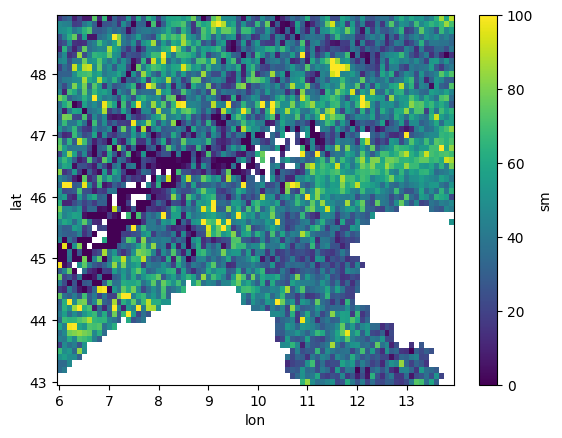

In [22]:
gridded_ds["sm"].plot.imshow(x="lon", y="lat")

OK, that result looks awful. That's because we made a crucial omission when regridding: we didn't account for the fact that there are several days worth of data in here. `kd_tree.resample_nearest` doesn't work in more than two dimensions, it only finds the nearest neighbor to each grid point across the *entire* swath dataset and assigns that value to the grid point. That doesn't really work if you have multiple overlapping swaths, and in any case it's not useful to get back a single image from a multi-day or even multi-year dataset. We'd rather have one image per day, or even per pass.

To do this efficiently, we can turn our resampling workflow into a function and use Xarray's `groupby` and `map` methods to apply the regridding separately to the data from each unique date in the dataset, and then concatenate all those results together into a cube.

(To make this work, we need to add just one additional step into the process, which is to sort all our observations in ascending order before selecting them from the dataset.)

In [23]:

def regrid_swath(swath_data, grid_def, radius_of_influence=15000, **kwargs):
    """
    Resample a swath image to a grid using pyresample.
    """
    # Create a swath definition for the image
    swath_def = SwathDefinition(swath_data.lon.values, swath_data.lat.values)
    # Get the index of the nearest observation in the swath data for each point in the grid.
    grid_obs = kd_tree.resample_nearest(swath_def, swath_data.obs.values, grid_def, radius_of_influence=radius_of_influence, **kwargs)
    mask = grid_obs.mask
    lons = grid_def.lons[~mask].flatten()
    lats = grid_def.lats[~mask].flatten()
    obs = grid_obs.compressed()
    # sort observations and corresponding lats/lons
    order = np.argsort(obs)
    sorted_obs = obs[order]
    sorted_lats = lats[order]
    sorted_lons = lons[order]
    # select and reindex swath data
    grid_data = swath_data.sel(obs=sorted_obs)
    grid_data["lon"] = ("obs", sorted_lons)
    grid_data["lat"] = ("obs", sorted_lats)
    grid_data = grid_data.set_index(obs=["lon", "lat"])
    grid_data = grid_data.unstack("obs")
    return grid_data

daily_alps_grid_ds = alps_ds.groupby('time.date').map(regrid_swath, grid_def=grid_def, fill_value=None, radius_of_influence=13000)

In [24]:
daily_alps_grid_ds["date"] = daily_alps_grid_ds.date.astype('datetime64[ns]')
daily_alps_grid_ds

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 31, beam: 3, lon: 80, lat: 60)
Coordinates:
  * lon               (lon) float64 640B 6.0 6.1 6.2 6.3 ... 13.6 13.7 13.8 13.9
  * lat               (lat) float64 480B 43.0 43.1 43.2 43.3 ... 48.7 48.8 48.9
    time              (date, lon, lat) datetime64[ns] 1MB NaT ... 2018-05-31T...
  * date              (date) datetime64[ns] 248B 2018-05-01 ... 2018-05-31
Dimensions without coordinates: beam
Data variables: (12/31)
    f_land            (date, beam, lon, lat) float32 2MB nan nan ... 0.995 1.0
    sat_track_azi     (date, lon, lat) float32 595kB nan nan nan ... 344.5 344.5
    abs_line_number   (date, lon, lat) float64 1MB nan nan ... 6.199e+08
    param_db_version  (date, lon, lat) float32 595kB nan nan nan ... 3.0 3.0 3.0
    warp_nrt_version  (date, lon, lat) float32 595kB nan nan nan ... 3.0 3.0 3.0
    node_num          (date, lon, lat) float64 1MB nan nan nan ... 64.0 64.0
    ...                ...
    frozen_prob       (date, lon, lat) float32 595kB nan nan nan ... 0.0 0.0 0.0
    wetland           (date, lon, lat) float32 595kB nan nan nan ... 4.0 2.0 0.0
    topo              (date, lon, lat) float32 595kB nan nan nan ... 8.0 9.0 8.0
    kp                (date, beam, lon, lat) float32 2MB nan nan ... 0.0404 0.04
    swath_indicator   (date, lon, lat) float32 595kB nan nan nan ... 1.0 1.0 1.0
    sat_id            (date, lon, lat) float64 1MB nan nan nan ... 3.0 3.0 3.0
Attributes:
    spacecraft_id:  2
    sat_id:         3

In [25]:
alps_ds

<xarray.Dataset> Size: 17MB
Dimensions:           (obs: 88803, beam: 3)
Coordinates:
    lon               (obs) float32 355kB 13.97 13.92 13.88 ... 7.621 7.573
    lat               (obs) float32 355kB 43.61 43.5 43.39 ... 43.1 43.13 43.03
    time              (obs) datetime64[ns] 710kB 2018-05-01T09:18:54.375000 ....
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 1MB nan nan nan nan ... nan nan nan
    sat_track_azi     (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    abs_line_number   (obs) float64 710kB nan nan nan nan ... nan nan nan nan
    param_db_version  (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    warp_nrt_version  (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    node_num          (obs) float64 710kB nan nan nan nan ... nan nan nan nan
    ...                ...
    frozen_prob       (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    wetland           (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    topo              (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    kp                (obs, beam) float32 1MB nan nan nan nan ... nan nan nan
    swath_indicator   (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    sat_id            (obs) float64 710kB nan nan nan nan ... nan nan nan nan
Attributes:
    spacecraft_id:  2
    sat_id:         3

Let's plot our data. We've done a good job of getting an image for each day that's filled in the swath area, while still leaving gaps where there really is no coverage. 

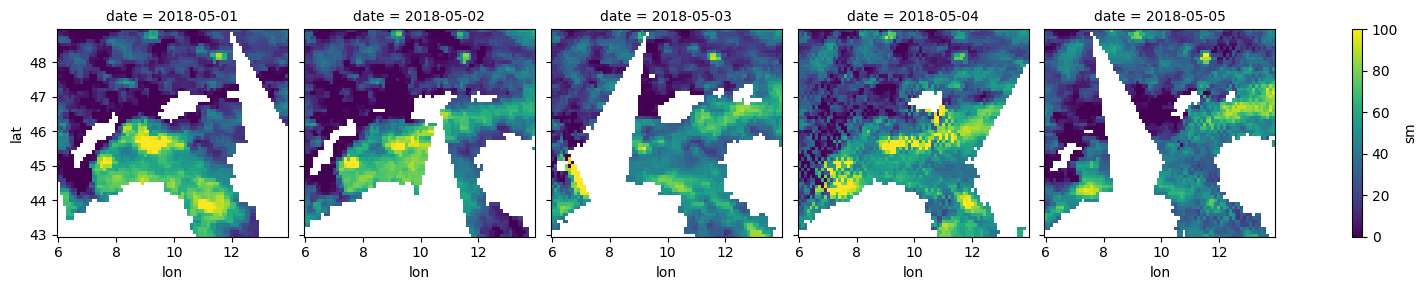

In [26]:
daily_alps_grid_ds.isel(date=slice(0,5)).sm.plot.imshow(x='lon', y='lat', col='date', col_wrap=5)

However, notice that there are some artifacts on the fourth and fifth days. This is because we still have some overlapping data here, as some areas can be covered by several passes per day. 

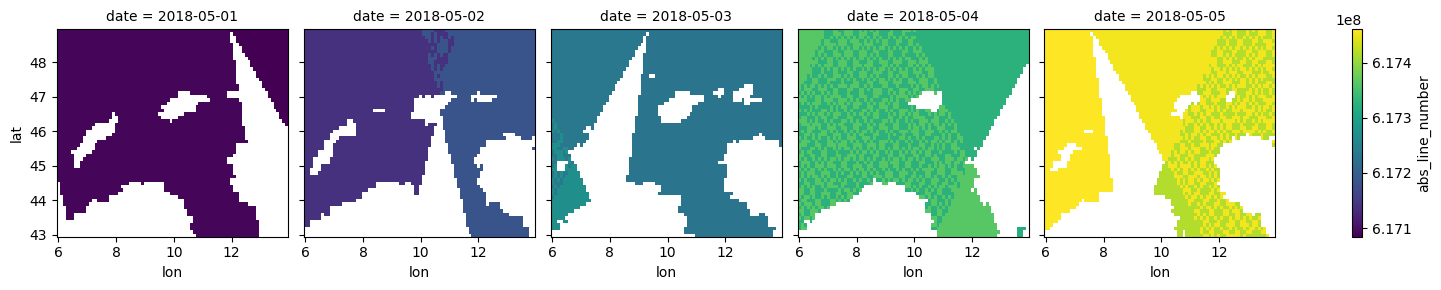

In [27]:
daily_alps_grid_ds.isel(date=slice(0,5)).abs_line_number.plot.imshow(x='lon', y='lat', col='date', col_wrap=5)

In [28]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming `full_grid_ssm` is already defined and has a 'date' dimension
resampled = daily_alps_grid_ds.sm.resample(date="5D").mean()
interval_left_bounds = resampled.date.values.astype('datetime64[D]')
interval_right_bounds = np.hstack((resampled.date.values.astype('datetime64[D]')[1:] - np.timedelta64(1, "D"),
                                   daily_alps_grid_ds.date.values[-1].astype('datetime64[D]')))

# Function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the current figure
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    resampled.isel(date=frame).plot(x="lon", y="lat", vmin=0, vmax=40, cmap="BrBG", ax=ax,
                                    cbar_kwargs={'label': 'Soil Moisture (% saturation)'})
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    left_bound = interval_left_bounds[frame]
    right_bound = interval_right_bounds[frame]
    if left_bound != right_bound:
        plt.title(f"Mean ASCAT Soil Moisture\n"
                  f"{left_bound} through {right_bound}")
    else:
        plt.title(f"Mean ASCAT Soil Moisture\n{left_bound}")


fig = plt.figure()
num_frames = resampled.sizes['date']
ani = FuncAnimation(fig, update, frames=range(num_frames), repeat=True)

html = HTML(ani.to_jshtml())
display(html)
plt.close()

# To save the animation as a GIF or MP4, uncomment one of the lines below
# ani.save('animation.gif', writer='imagemagick')
# ani.save('animation.mp4', writer='ffmpeg')

However, to correct the artifacts at a daily level we can try grouping by both date and hour of the day, and then taking the mean of the data over the hours for each date. This way we can get a single image for each day that represents the average soil moisture over the day.

We'll make a custom "grouper" array for this, making use of a pandas `MultiIndex`.

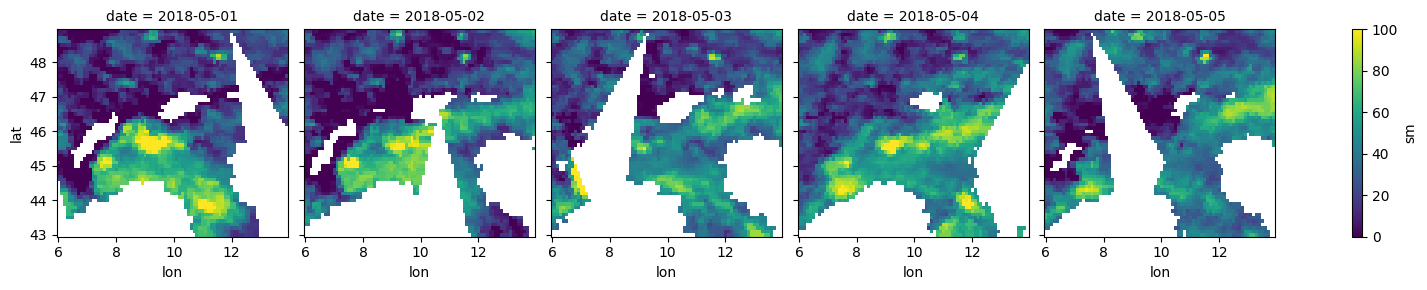

In [29]:
from flox.xarray import xarray_reduce
# group by both date and swath indicator
# groups = xr.apply_ufunc(regrid_swath, alps_ds.groupby(grouper)
import pandas as pd
grouper = xr.DataArray(
    pd.MultiIndex.from_arrays(
        [
            alps_ds["time.date"].values,
            alps_ds["time.hour"].values,
        ],
        names=["date", "hour"],
    ),
    coords={"obs": alps_ds["obs"]},
)
daily_alps_grid_ds_hourly = alps_ds.groupby(grouper).map(regrid_swath, grid_def=grid_def, fill_value=None, radius_of_influence=13000)
daily_alps_grid_ds = daily_alps_grid_ds_hourly.unstack("group").mean("hour")
daily_alps_grid_ds.isel(date=slice(0,5)).sm.plot(x='lon', y='lat', col='date', col_wrap=5)

This may be a bit of a naive approach though, since morning soil moisture retrievals can differ significantly from those in the evening. This is why the artifacts we saw earlier were so obvious in the first place. We might want to have two dimensions in our dataset that separate morning and evening retrievals:

Text(0.5, 1.0, 'Difference in mean surface soil moisture\n(morning - evening; % saturation)\n2018-05-01 - 2018-05-31')

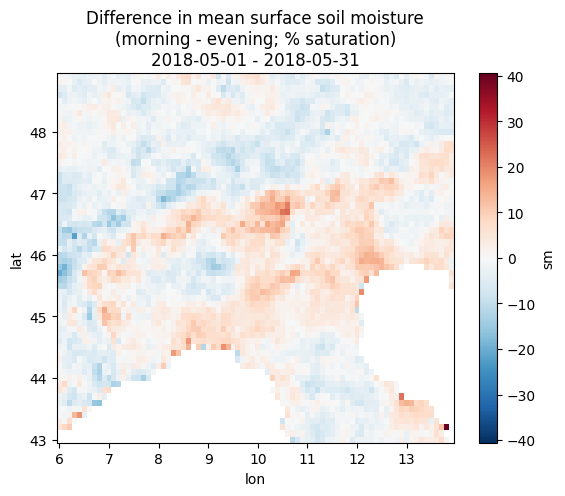

In [30]:
from flox.xarray import xarray_reduce
# group by both date and swath indicator
# groups = xr.apply_ufunc(regrid_swath, alps_ds.groupby(grouper)
import pandas as pd
grouper = xr.DataArray(
    pd.MultiIndex.from_arrays(
        [
            alps_ds["time.date"].values,
            alps_ds["time.hour"].values,
            # use a boolean to create a string variable for evening/morning definition
            np.array(["evening", "morning"])[1*(alps_ds["time.hour"].values < 12)],
        ],
        names=["date", "hour", "time_of_day"],
    ),
    coords={"obs": alps_ds["obs"]},
)
time_of_day="evening"
daily_alps_grid_ds_hourly_by_time_of_day = alps_ds.groupby(grouper).map(regrid_swath, grid_def=grid_def, fill_value=None, radius_of_influence=13000)
daily_alps_grid_ds_by_time_of_day = daily_alps_grid_ds_hourly_by_time_of_day.unstack("group").mean("hour")

daily_alps_grid_ds_by_time_of_day.mean("date").sm.diff(dim="time_of_day").isel(time_of_day=0).plot(x='lon', y='lat')
plt.gca().set_title("Difference in mean surface soil moisture\n(morning - evening; % saturation)\n"
f"{daily_alps_grid_ds_by_time_of_day.date.min().values} - {daily_alps_grid_ds_by_time_of_day.date.max().values}")
#plt.suptitle(f"Average surface soil moisture (% saturation)\n{daily_alps_grid_ds_by_time_of_day.date.min().values}-{daily_alps_grid_ds_by_time_of_day.date.max().values}", y=1.02)

In [31]:
daily_alps_grid_ds["date"] = daily_alps_grid_ds.date.astype('datetime64')

/tmp/ipykernel_129132/3840049210.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  daily_alps_grid_ds["date"] = daily_alps_grid_ds.date.astype('datetime64')


If you need more sophisticated resampling or a way to consider more neighbors, you can also get fancy with custom functions in pyresample - they offer a gaussian resampler but also a way to pass your own neighbor-resampling function.

Or we can look at some time series of individual points. Let's pick a few in the region of Milan.

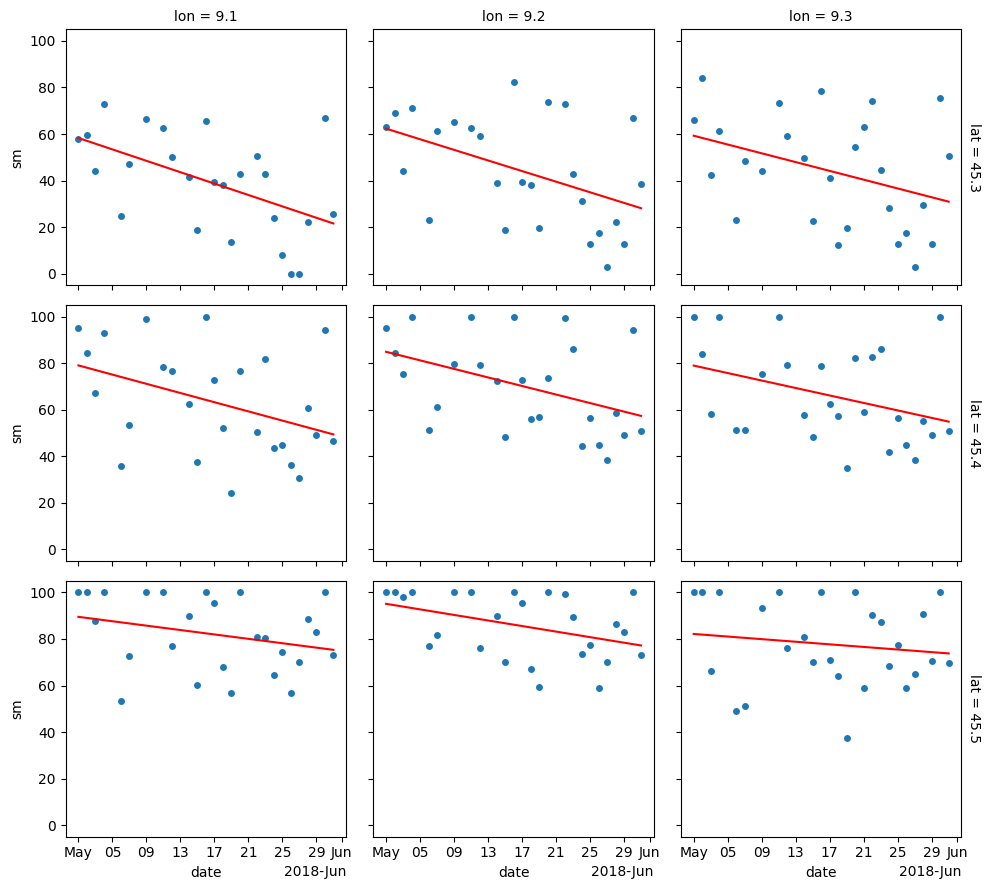

In [32]:
milan_grid_ssm = daily_alps_grid_ds.sel(lat=slice(45.3, 45.6), lon=slice(9.0, 9.3)).sm
regression = milan_grid_ssm.polyfit(dim="date", deg=1)
regression_lines = (milan_grid_ssm["date"].astype(np.float32) * regression.polyfit_coefficients.sel(degree=1) + regression.polyfit_coefficients.sel(degree=0))
facets = milan_grid_ssm.plot.scatter(row="lat", col="lon", x="date")
# plot regression lines
for i, _ in enumerate(facets.axs):
    for j, ax in enumerate(_):
        ax.plot(regression_lines.date, regression_lines.isel(lat=i, lon=j) ,color="red")

Now we can try the same somewhere in the alps and compare the trends.

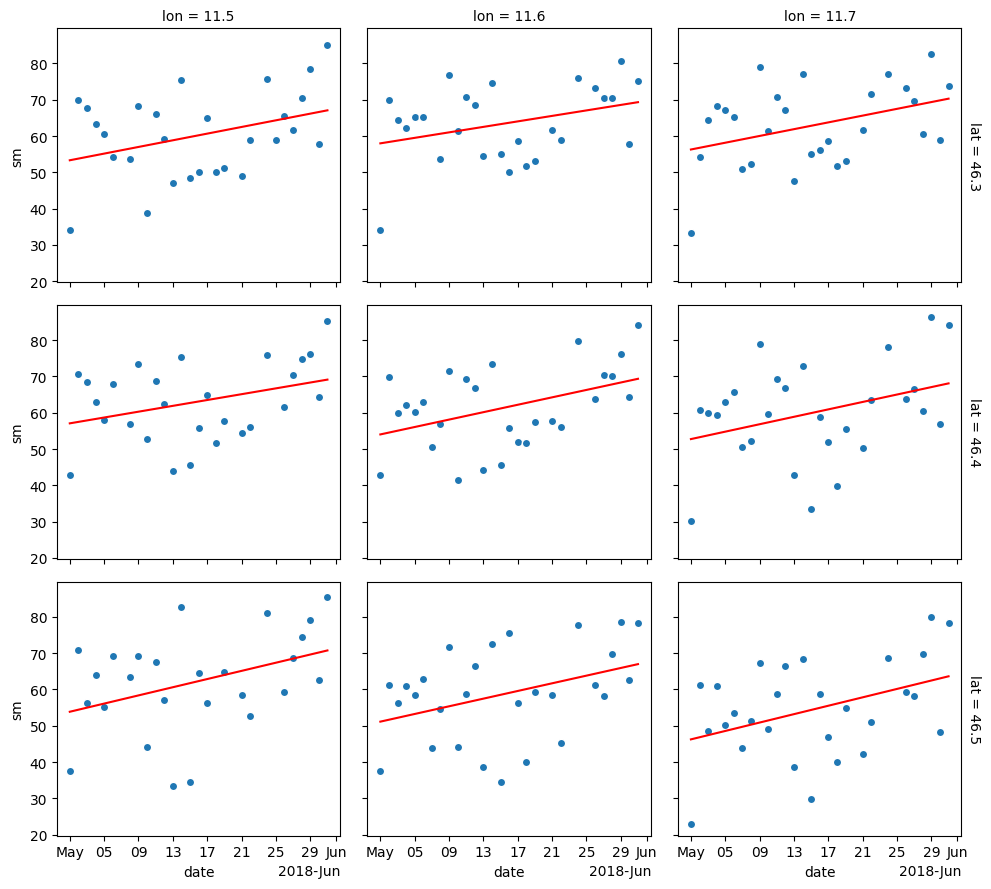

In [33]:

mountain_grid_ssm = daily_alps_grid_ds.sel(lat=slice(46.3, 46.6), lon=slice(11.4, 11.7)).sm
regression = mountain_grid_ssm.polyfit(dim="date", deg=1)
regression_lines = (mountain_grid_ssm["date"].astype(np.float32) * regression.polyfit_coefficients.sel(degree=1) + regression.polyfit_coefficients.sel(degree=0))
facets = mountain_grid_ssm.plot.scatter(row="lat", col="lon", x="date")
# plot regression lines
for i, _ in enumerate(facets.axs):
    for j, ax in enumerate(_):
        ax.plot(regression_lines.date, regression_lines.isel(lat=i, lon=j) ,color="red")

## Converting Native files to NetCDF

We just had a nice lesson for a situation where all the swath products intersecting our region of interest during our period of interest will fit on our disk and in memory. What if we want to do an analysis of a smallish area over a much longer time period? We can do some clipping as we download the files to avoid filling our hard drive and RAM with data we don't need.

It would also be nice to have all the data as netcdf files, since these are much nicer to use with packages like xarray and dask, which will help us manage memory and parallelism.

Here is a simple function that will iterate through an EODAG search result and convert them all to NetCDF files, clipping them to a region of interest as we go if desired. By default this is all it does, but if you know you can do away with the original swath files, you can set `delete_original=True` to remove them after conversion. This isn't implemented as part of the ascat package, but you can copy it for your own scripts if you find it useful.
<a id='to_netcdf'></a>

In [34]:
import shutil

def trim_ascat_data_to_roi(ds, footprint):
    ds = ds.sel(obs=(ds.lon > footprint["lonmin"])
                & (ds.lat > footprint["latmin"])
                & (ds.lon < footprint["lonmax"])
                & (ds.lat < footprint["latmax"]))
    return ds

def convert_ascat_native_to_netcdf(
        products,
        native_reader,
        footprint=None,
        output_directory=None,
        delete_original=False
):
    for product in products:
        # Download the product and read its data
        dl_dir = product.download()
        dl_dir = Path(dl_dir)
        fname = dl_dir/f"{dl_dir.name}.nat"
        product_file = native_reader(fname)
        data, _ = product_file.read(to_xarray=True)
        nc_fname = f"{dl_dir.name}.nc"

        if footprint is not None:
            # Trim the data to the region of interest
            data = trim_ascat_data_to_roi(data, footprint)
            # We can append "TRIMMED_" to the original filename,
            # to indicate it does not contain all the original data.
            # You might want a more sophisticated way of naming the file
            # to indicate the exact region.
            nc_fname = f"TRIMMED_{nc_fname}"

        # write to netcdf in the same location as the original product directory
        # if an output directory is not provided
        output_directory = output_directory or dl_dir.parent
        nc_fname = output_directory/nc_fname
        data.to_netcdf(nc_fname)

        # remove the original product directory and its contents, if requested
        if delete_original:
            shutil.rmtree(dl_dir)

In [35]:
netcdf_directory = Path("/tmp/eodag_eumetsat_nc")
netcdf_directory.mkdir(exist_ok=True)
convert_ascat_native_to_netcdf(products, AscatL2File, footprint=footprint, output_directory=netcdf_directory)

Let's try reading them back in. Now that we have normal netCDF files, we no longer need a special native reader to open them up, we can just use xarray.

In [36]:
ds = xr.open_mfdataset(netcdf_directory.glob("*.nc"), combine="nested", concat_dim="obs", engine="netcdf4")
ds

<xarray.Dataset> Size: 17MB
Dimensions:           (obs: 88803, beam: 3)
Coordinates:
    lon               (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    lat               (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    time              (obs) datetime64[ns] 710kB dask.array<chunksize=(173,), meta=np.ndarray>
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 1MB dask.array<chunksize=(173, 3), meta=np.ndarray>
    sat_track_azi     (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    abs_line_number   (obs) int32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    param_db_version  (obs) uint16 178kB dask.array<chunksize=(173,), meta=np.ndarray>
    warp_nrt_version  (obs) uint16 178kB dask.array<chunksize=(173,), meta=np.ndarray>
    node_num          (obs) float64 710kB dask.array<chunksize=(173,), meta=np.ndarray>
    ...                ...
    frozen_prob       (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    wetland           (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    topo              (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    kp                (obs, beam) float32 1MB dask.array<chunksize=(173, 3), meta=np.ndarray>
    swath_indicator   (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    sat_id            (obs) float64 710kB dask.array<chunksize=(173,), meta=np.ndarray>
Attributes:
    spacecraft_id:  2
    orbit_start:    60068
    sat_id:         3